In [1]:
import pandas as pd
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import random
import time
from tqdm import tqdm
import torchmetrics
from torchvision.datasets import ImageFolder

# Data

In [2]:
DATA_PATH = '/home/ivainn/Alex/birds-400/dataset/'

birds_df = pd.read_csv(os.path.join(DATA_PATH, 'birds.csv'))
birds_df.head()

,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [3]:
print('TRAIN IMAGES NUM: ', len(birds_df[birds_df['data set'] == 'train']))
print('VAL IMAGES NUM: ', len(birds_df[birds_df['data set'] == 'valid']))
print('TEST IMAGES NUM: ', len(birds_df[birds_df['data set'] == 'test']))
print('IMAGES SHAPE: ', cv2.imread(os.path.join(DATA_PATH, birds_df.iloc[0].filepaths)).shape)

TRAIN IMAGES NUM:  58388
VAL IMAGES NUM:  2000
TEST IMAGES NUM:  2000
IMAGES SHAPE:  (224, 224, 3)


Let's look at some pictures from the dataset.

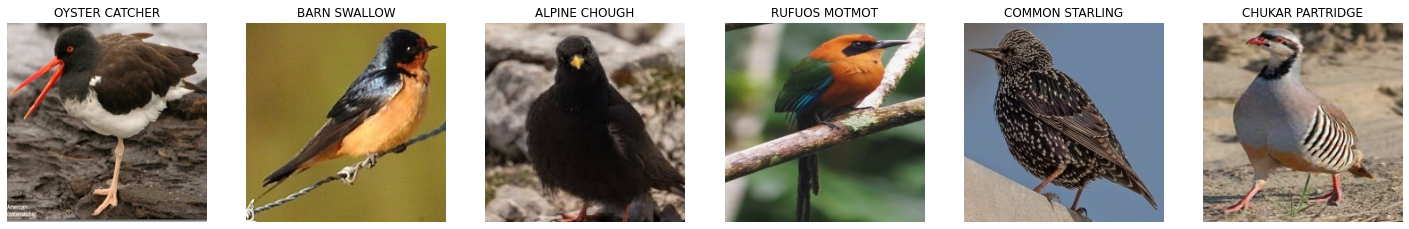

In [4]:
random.seed(42)
IMG_NUM = 6
indices = random.sample(list(range(len(birds_df))), IMG_NUM)
fig, axs = plt.subplots(1, IMG_NUM, figsize=(25, 25))
for index, ax in zip(indices, axs):
    ax.axis(False)
    ax.set(title=birds_df.iloc[index].labels)
    image = cv2.imread(os.path.join(DATA_PATH, birds_df.iloc[index].filepaths))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
plt.show()

Lets check the class balance

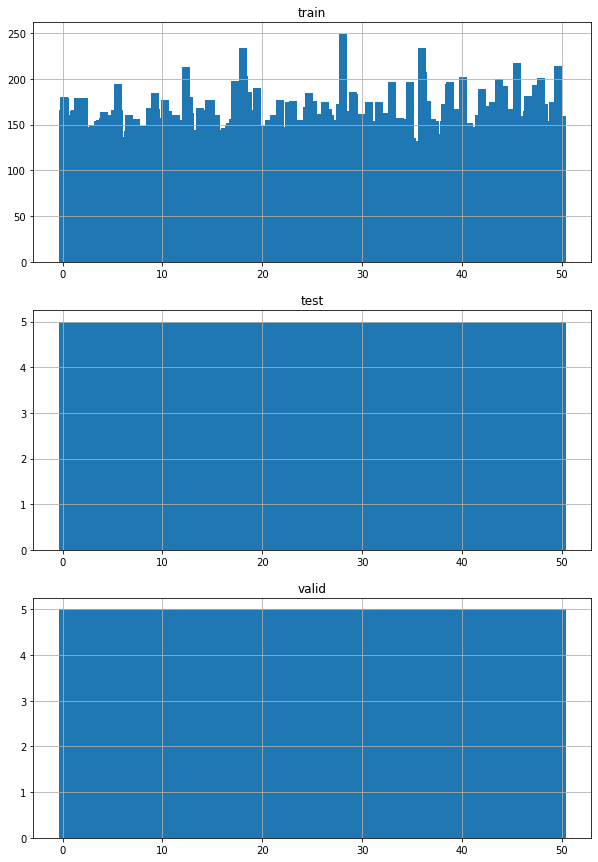

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
for subset, ax in zip(['train', 'test', 'valid'], axs):
    part_df = birds_df[birds_df['data set'] == subset]
    images_num = part_df.groupby('labels').count().values[:, 0]
    ax.bar(np.linspace(0, 50, 400), images_num)
    ax.grid(True)
    ax.set(title=subset)
fig.show()

Nice balance.

Lets create datasets and dataloaders (at first without any augmentations).

I'll reshape images to 56x56 to speed up learning.

In [6]:
TRAIN_BATCH_SIZE = 512

VAL_BATCH_SIZE = 128
NUM_WORKERS = 4

datasets = {}
dataloaders = {}
for subset in ['train', 'valid', 'test']:
    if subset == 'train':
        batch_size = TRAIN_BATCH_SIZE
    else:
        batch_size = VAL_BATCH_SIZE
    datasets[subset] = ImageFolder(
        os.path.join(DATA_PATH, subset),
        transform=transforms.Compose(
            [transforms.Resize(56),
            transforms.ToTensor()]
        )
    )
    dataloaders[subset] = DataLoader(datasets[subset], batch_size, NUM_WORKERS)
    print('LEN OF ' + subset.upper() + ': ' + str(len(datasets[subset])))

LEN OF TRAIN: 58388
LEN OF VALID: 2000
LEN OF TEST: 2000


# Models
I'll use EfficientNet models and ResNet models from torchvision.models.

Lets consider following models:

    1. EfficientNet-b0: 5.3M params
    3. ResNet18: 11.7M params

### EfficientNet
EfficientNet is a class of convolutional models whose authors have found the optimal way to scale models. 
Due to efficient scaling, it allows you to get SOTA results with a relatively small model size. 
The scaling algorithm is described in more detail in the original article: https://arxiv.org/pdf/1905.11946.pdf

### ResNet
ResNet is a class of models that appeared as an alternative to VGG and surpassed them. The main idea is SkipConnections - adding Identity layers to the model. This solves the problem of fading gradients and makes it possible to train large models.

In [7]:
efficient_net_b0 = torchvision.models.efficientnet_b0(pretrained=False)
resnet18 = torchvision.models.resnet18(pretrained=False)

Check the parameters num:

In [8]:
def get_param_num(model):
    return sum(p.numel() for p in model.parameters())

print('EfficientNet-b0 has ' + str(get_param_num(efficient_net_b0)) + ' parameters')
print('Resnet18 has ' + str(get_param_num(resnet18)) + ' parameters')

EfficientNet-b0 has 5288548 parameters
Resnet18 has 11689512 parameters


### Training from scratch
To begin with, we will train the models from scratch.

In [9]:
print('EfficientNet-b0 classifier: ' + str(efficient_net_b0.classifier))
print('ResNet18 classifier: ' + str(resnet18.fc))


EfficientNet-b0 classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
ResNet18 classifier: Linear(in_features=512, out_features=1000, bias=True)


In [10]:
CLASSES_NUM = 400

efficient_net_b0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=CLASSES_NUM, bias=True)
)

resnet18.fc = nn.Linear(in_features=512, out_features=CLASSES_NUM, bias=True)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(
    model, criterion, optimizer, epoch_num=10, 
    train_dataloader=dataloaders['train'], 
    val_dataloader=dataloaders['valid'],
    test_dataloader=dataloaders['test']
):
    torch.cuda.empty_cache()
    model = model.to(device)
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    
    for epoch in (range(epoch_num)):        
        train_loss_step = []
        train_accuracy_step = []
        val_loss_step = []
        val_accuracy_step = []
        
        # Train cycle
        model.train()
        for images, targets in tqdm(train_dataloader):
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, targets)
            accuracy = torchmetrics.Accuracy()(preds.cpu(), targets.cpu())
            
            loss.backward()
            optimizer.step()
            train_loss_step.append(loss.item())
            train_accuracy_step.append(accuracy.item())
        
        train_loss.append(np.mean(train_loss_step))
        train_accuracy.append(np.mean(train_accuracy_step))
        del images, targets
        
        # Validation cycle
        torch.cuda.empty_cache()
        model.eval()
        for images, targets in val_dataloader:
            images = images.to(device)
            targets = targets.to(device)
            
            preds = model(images)
            loss = criterion(preds, targets)
            accuracy = torchmetrics.Accuracy()(preds.cpu(), targets.cpu())
            
            val_loss_step.append(loss.item())
            val_accuracy_step.append(accuracy.item())
        
        val_loss.append(np.mean(val_loss_step))
        val_accuracy.append(np.mean(val_accuracy_step))
        
        print('-'*100)
        print('Epoch {} ends'.format(epoch + 1))
        print('Train loss = {}'.format(train_loss[-1]))
        print('Train accuracy = {}'.format(train_accuracy[-1]))
        print('Val loss = {}'.format(val_loss[-1]))
        print('Val accuracy = {}'.format(val_accuracy[-1]))
        
    return [train_loss, train_accuracy, val_loss, val_accuracy]

In [12]:
criterion = nn.CrossEntropyLoss()

train_history = []

for model in [efficient_net_b0, resnet18]:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_history.append(train(model, criterion, optimizer))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.78it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 5.588885469022005
Train accuracy = 0.015516304354304853
Val loss = 4.826222687959671
Val accuracy = 0.05058593751164153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:05<00:00,  1.77it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 4.427996367993562
Train accuracy = 0.08924252718039181
Val loss = 3.7971447557210922
Val accuracy = 0.15605468768626451


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:05<00:00,  1.77it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 3.5630345966504966
Train accuracy = 0.20864809777425683
Val loss = 2.815557137131691
Val accuracy = 0.32656249962747097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:05<00:00,  1.76it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 2.895816773953645
Train accuracy = 0.3322927989389585
Val loss = 2.376243382692337
Val accuracy = 0.41054687462747097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:05<00:00,  1.76it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 2.461855175184167
Train accuracy = 0.41545855973077855
Val loss = 2.0308188423514366
Val accuracy = 0.48847656324505806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:05<00:00,  1.77it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 2.1024182620255845
Train accuracy = 0.4899762228779171
Val loss = 2.135148912668228
Val accuracy = 0.49746093712747097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.77it/s]


----------------------------------------------------------------------------------------------------
Epoch 7 ends
Train loss = 1.8784283327019733
Train accuracy = 0.5338247283645298
Val loss = 1.7085408866405487
Val accuracy = 0.5790039077401161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:05<00:00,  1.77it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 1.5905022113219551
Train accuracy = 0.598685462060182
Val loss = 1.5548744797706604
Val accuracy = 0.5802734382450581


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.78it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 1.401290193847988
Train accuracy = 0.6397588315217392
Val loss = 1.5914612784981728
Val accuracy = 0.5958007797598839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.79it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 1.2545138576756354
Train accuracy = 0.6728668477224267
Val loss = 1.397115994244814
Val accuracy = 0.65478515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.09it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 4.452879530450572
Train accuracy = 0.12853260869565217
Val loss = 4.463786482810974
Val accuracy = 0.13388671912252903


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.10it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 2.7347916789676834
Train accuracy = 0.37459239130434785
Val loss = 2.655642956495285
Val accuracy = 0.36826171912252903


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:55<00:00,  2.09it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 1.975518710716911
Train accuracy = 0.5256929345752882
Val loss = 2.159760646522045
Val accuracy = 0.4769531264901161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:56<00:00,  2.05it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 1.4676623033440632
Train accuracy = 0.6338043477224267
Val loss = 1.7749027833342552
Val accuracy = 0.54736328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.10it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 1.1050685540489529
Train accuracy = 0.7158118206521739
Val loss = 2.110289126634598
Val accuracy = 0.49199218675494194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:55<00:00,  2.07it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 0.7484003922213679
Train accuracy = 0.8026868208594944
Val loss = 1.3170368112623692
Val accuracy = 0.6682617180049419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.12it/s]


----------------------------------------------------------------------------------------------------
Epoch 7 ends
Train loss = 0.4317736309507619
Train accuracy = 0.8882948367492013
Val loss = 1.566025085747242
Val accuracy = 0.6204101555049419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.13it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 0.2918504955975906
Train accuracy = 0.9261922556421031
Val loss = 1.6413157284259796
Val accuracy = 0.6234375014901161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.10it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 0.20422194114197856
Train accuracy = 0.9492425270702528
Val loss = 1.6146173924207687
Val accuracy = 0.6437500007450581


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.13it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 0.09948278442025185
Train accuracy = 0.980016983591992
Val loss = 1.2289429046213627
Val accuracy = 0.7077148444950581


In [23]:
def plot_train_histories(train_histories, model_names=['EfficientNet-b0', 'ResNet18']):
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    axs[0][0].set(title='Train Loss')
    axs[0][0].grid(True)
    axs[0][1].set(title='Val Loss')
    axs[0][1].grid(True)
    axs[1][0].set(title='Train Accuracy')
    axs[1][0].grid(True)
    axs[1][1].set(title='Val Accuracy')
    axs[1][1].grid(True)
    for history, model_name in zip(train_histories, model_names):
        train_loss, train_acc, val_loss, val_acc = history
        axs[0][0].plot(train_loss, label=model_name)
        axs[0][1].plot(val_loss, label=model_name)
        axs[1][0].plot(train_acc, label=model_name)
        axs[1][1].plot(val_acc, label=model_name)
    
    axs[0][0].legend()
    axs[0][1].legend()
    axs[1][0].legend()
    axs[1][1].legend()

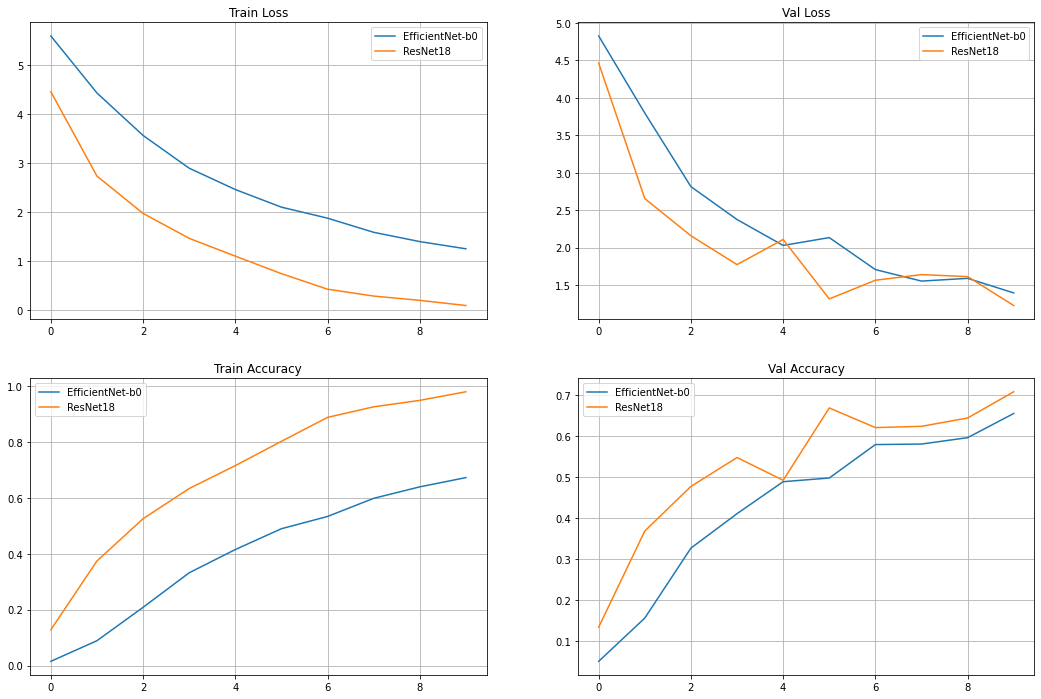

In [24]:
plot_train_histories(train_history)

We can see that on the training dataset ResNet turned out to be significantly better than EfficientNet, and on the validation dataset we see that ResNet has been overfitted. A little later we will try to add augmentation and see how this will affect convergence. 

### Finetuning

And now let's take pretrained models and do finetuning.

For the beginning lets try freezing almost all backbone layers, and train only one conv layer and FC layer.

In [41]:
efficient_net_b0 = torchvision.models.efficientnet_b0(pretrained=True)
resnet18 = torchvision.models.resnet18(pretrained=True)

CLASSES_NUM = 400

# Freeze all layers
for model in [efficient_net_b0, resnet18]:
    for parameter in model.parameters():
        parameter.requires_grad = False

# Unfreeze last conv layer
for parameter in efficient_net_b0.features[-1].parameters():
    parameter.requires_grad = True
    
for parameter in resnet18.layer4[-1].parameters():
    parameter.requires_grad = True

efficient_net_b0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=CLASSES_NUM, bias=True)
)

resnet18.fc = nn.Linear(in_features=512, out_features=CLASSES_NUM, bias=True)

In [42]:
criterion = nn.CrossEntropyLoss()

train_history_finetuning = []

for model in [efficient_net_b0, resnet18]:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_history_finetuning.append(train(model, criterion, optimizer))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:52<00:00,  2.21it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 5.0394485639489215
Train accuracy = 0.0936107337474823
Val loss = 3.9686018228530884
Val accuracy = 0.22675781324505806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:52<00:00,  2.19it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 3.679033907600071
Train accuracy = 0.25280910328678463
Val loss = 3.4947135895490646
Val accuracy = 0.2711914060637355


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:52<00:00,  2.18it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 3.1911207468613334
Train accuracy = 0.3245244565217391
Val loss = 3.368318110704422
Val accuracy = 0.30117187462747097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:50<00:00,  2.26it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 2.8773600806360657
Train accuracy = 0.3733627718427907
Val loss = 3.317688524723053
Val accuracy = 0.3017578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:52<00:00,  2.20it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 2.63972255665323
Train accuracy = 0.4157404891822649
Val loss = 3.3262850791215897
Val accuracy = 0.31142578087747097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:52<00:00,  2.18it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 2.459221607705821
Train accuracy = 0.447829483643822
Val loss = 3.359055534005165
Val accuracy = 0.30966796912252903


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:52<00:00,  2.19it/s]


----------------------------------------------------------------------------------------------------
Epoch 7 ends
Train loss = 2.3156190436819326
Train accuracy = 0.47241168488626895
Val loss = 3.338228151202202
Val accuracy = 0.31416015699505806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:51<00:00,  2.23it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 2.1857202602469403
Train accuracy = 0.49791779893895854
Val loss = 3.388245791196823
Val accuracy = 0.31582031212747097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:51<00:00,  2.24it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 2.0732979028121283
Train accuracy = 0.5191236413043478
Val loss = 3.4111240953207016
Val accuracy = 0.30800781212747097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:50<00:00,  2.27it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 1.9825950819513072
Train accuracy = 0.535258152173913
Val loss = 3.3903342336416245
Val accuracy = 0.31074218824505806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:48<00:00,  2.35it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 3.62646107259004
Train accuracy = 0.2658118206521739
Val loss = 2.2049020007252693
Val accuracy = 0.47871093824505806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:48<00:00,  2.37it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 1.885086178779602
Train accuracy = 0.5589572009832963
Val loss = 1.833526648581028
Val accuracy = 0.5499023422598839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:48<00:00,  2.36it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 1.0737929079843604
Train accuracy = 0.7523505433746006
Val loss = 1.8147996291518211
Val accuracy = 0.5469726547598839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:48<00:00,  2.36it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 0.5109038542146268
Train accuracy = 0.8974388589029727
Val loss = 1.7822957709431648
Val accuracy = 0.5701171867549419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:48<00:00,  2.37it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 0.2099287634310515
Train accuracy = 0.9689843747926795
Val loss = 1.8222752884030342
Val accuracy = 0.56884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:48<00:00,  2.36it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 0.12494963310334993
Train accuracy = 0.9849150813144186
Val loss = 1.8507457822561264
Val accuracy = 0.56982421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:49<00:00,  2.33it/s]


----------------------------------------------------------------------------------------------------
Epoch 7 ends
Train loss = 0.06840048216931198
Train accuracy = 0.9918138586956522
Val loss = 1.8974040672183037
Val accuracy = 0.56494140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:50<00:00,  2.27it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 0.0992130010024361
Train accuracy = 0.986861412939818
Val loss = 1.9315464049577713
Val accuracy = 0.5593749992549419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:50<00:00,  2.27it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 0.05399775113100591
Train accuracy = 0.9936514947725379
Val loss = 1.9684221744537354
Val accuracy = 0.5564453117549419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:50<00:00,  2.30it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 0.06307079093935697
Train accuracy = 0.991654212060182
Val loss = 2.0237294659018517
Val accuracy = 0.5586914047598839


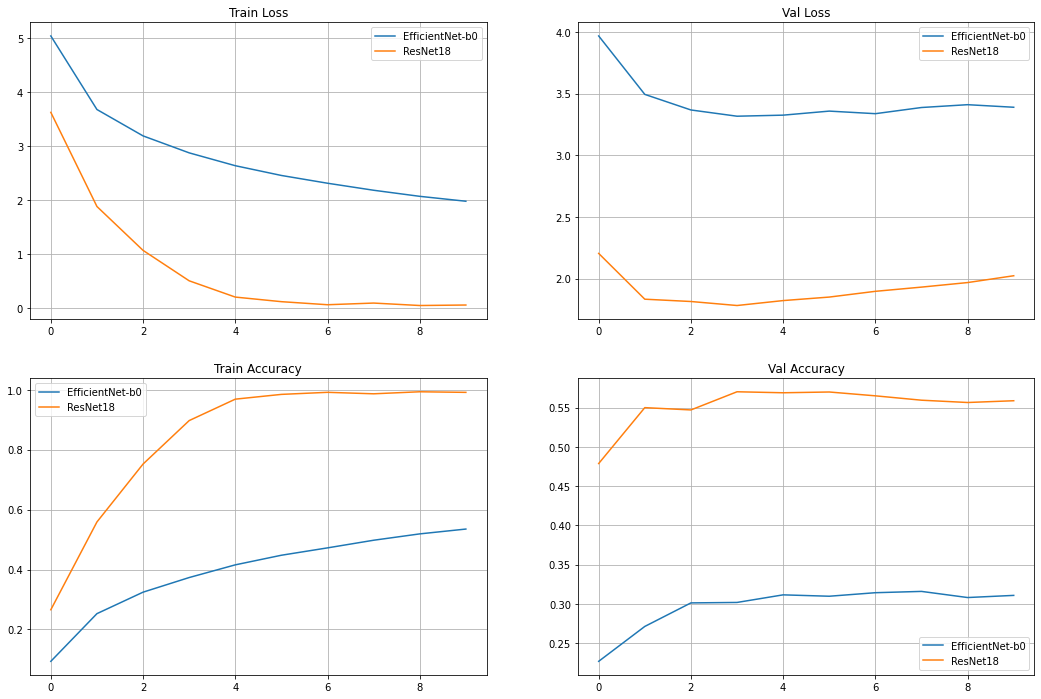

In [44]:
plot_train_histories(train_history_finetuning)

We see that with ResNet everything is the same as in the first experiment, and EfficientNet did not have enough freedom to learn. Let's defrost all the layers and try again.

In [45]:
efficient_net_b0 = torchvision.models.efficientnet_b0(pretrained=True)
resnet18 = torchvision.models.resnet18(pretrained=True)

CLASSES_NUM = 400

# Unfreeze all layers
for model in [efficient_net_b0, resnet18]:
    for parameter in model.parameters():
        parameter.requires_grad = True


efficient_net_b0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=CLASSES_NUM, bias=True)
)

resnet18.fc = nn.Linear(in_features=512, out_features=CLASSES_NUM, bias=True)

In [46]:
criterion = nn.CrossEntropyLoss()

train_history_finetuning_full = []

for model in [efficient_net_b0, resnet18]:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_history_finetuning_full.append(train(model, criterion, optimizer))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.78it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 3.3081611861353335
Train accuracy = 0.3423267665116683
Val loss = 1.0159078277647495
Val accuracy = 0.7442382797598839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.78it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 1.0389922515205714
Train accuracy = 0.7340591031572093
Val loss = 0.567317446693778
Val accuracy = 0.85302734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.79it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 0.5742912409098252
Train accuracy = 0.845169837060182
Val loss = 0.463768282905221
Val accuracy = 0.86962890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.80it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 0.3766885438691015
Train accuracy = 0.8973335597826086
Val loss = 0.4160750024020672
Val accuracy = 0.8854492194950581


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:05<00:00,  1.77it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 0.28653095584848653
Train accuracy = 0.9199864128361578
Val loss = 0.4172429060563445
Val accuracy = 0.8812500014901161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.79it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 0.1669954456065012
Train accuracy = 0.9536073368528615
Val loss = 0.38571041263639927
Val accuracy = 0.8984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:05<00:00,  1.76it/s]


----------------------------------------------------------------------------------------------------
Epoch 7 ends
Train loss = 0.13760717964690664
Train accuracy = 0.9591406252073205
Val loss = 0.42905127070844173
Val accuracy = 0.8898437507450581


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:05<00:00,  1.77it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 0.17855142721015474
Train accuracy = 0.9491440218427907
Val loss = 0.4155816826969385
Val accuracy = 0.8943359367549419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:03<00:00,  1.80it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 0.1567774262117303
Train accuracy = 0.9521705160970273
Val loss = 0.4125609342008829
Val accuracy = 0.8900390639901161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:04<00:00,  1.79it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 0.09865967906687571
Train accuracy = 0.97101222846819
Val loss = 0.4102641623467207
Val accuracy = 0.9009765610098839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:55<00:00,  2.08it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 2.7608952128368873
Train accuracy = 0.4160020382507988
Val loss = 1.5664610117673874
Val accuracy = 0.5995117202401161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:55<00:00,  2.08it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 1.1136088132858277
Train accuracy = 0.7174490488093832
Val loss = 1.438111811876297
Val accuracy = 0.6383789069950581


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.10it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 0.7174938730571581
Train accuracy = 0.8087839675986248
Val loss = 0.8324743583798409
Val accuracy = 0.7776367180049419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.10it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 0.3641271896984266
Train accuracy = 0.9024388587993124
Val loss = 0.894362635910511
Val accuracy = 0.7649414055049419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.10it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 0.27893313908058665
Train accuracy = 0.9229110054347827
Val loss = 0.7549225203692913
Val accuracy = 0.7989257797598839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.09it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 0.19823962508336357
Train accuracy = 0.9457065219464509
Val loss = 0.8081844747066498
Val accuracy = 0.8005859367549419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:54<00:00,  2.10it/s]


----------------------------------------------------------------------------------------------------
Epoch 7 ends
Train loss = 0.1895852328642555
Train accuracy = 0.9463111410970273
Val loss = 0.6735503636300564
Val accuracy = 0.8326171860098839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:55<00:00,  2.08it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 0.1373929687168287
Train accuracy = 0.9615794834883317
Val loss = 0.658829215914011
Val accuracy = 0.83740234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:55<00:00,  2.06it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 0.1040975653282974
Train accuracy = 0.9696433424949646
Val loss = 0.7433343064039946
Val accuracy = 0.8162109367549419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:55<00:00,  2.07it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 0.13616392664287402
Train accuracy = 0.9607269022775733
Val loss = 0.794519130140543
Val accuracy = 0.8121093735098839


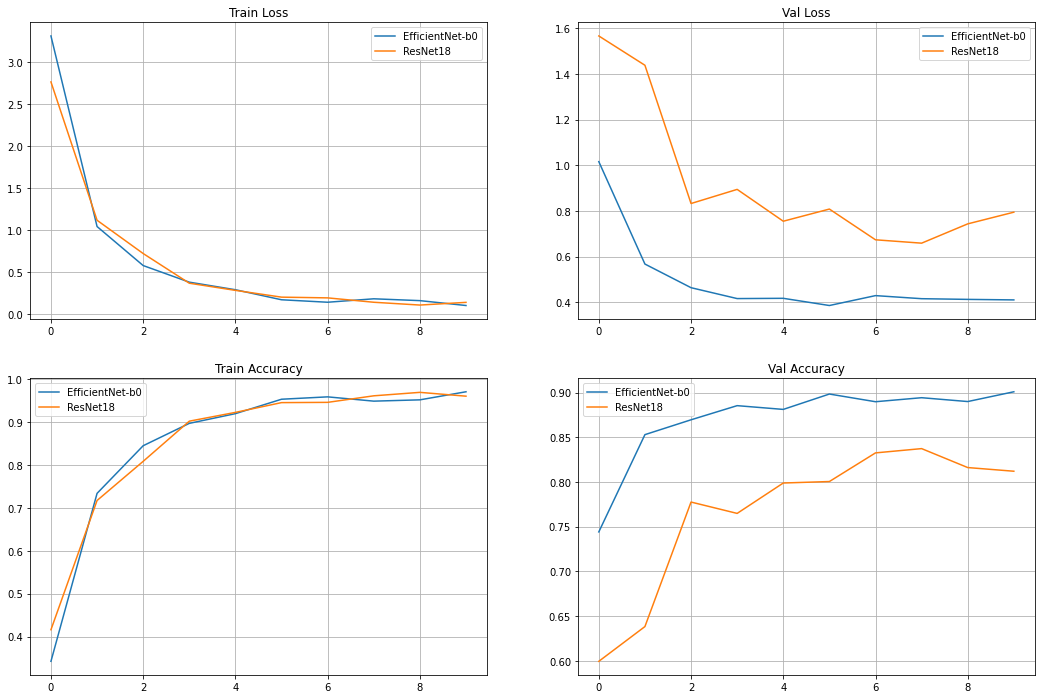

In [52]:
plot_train_histories(train_history_finetuning_full)

Now lets repeat the first and the third experiment with augmentations.

In [68]:
# Caclulating std and mean
channels_sum = 0
channels_sqr_sum = 0 
num_batches = 0

for images, _ in tqdm(dataloaders['train']):
    channels_sum += torch.mean(images, dim=[0, 2, 3]).detach()
    channels_sqr_sum += torch.mean(images**2, dim=[0, 2, 3]).detach()
    num_batches += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:42<00:00,  2.71it/s]


In [69]:
means = channels_sum / num_batches
stds = np.sqrt((channels_sqr_sum / num_batches - means ** 2))
print('Means: ', means)
print('STDs: ', stds)

Means:  tensor([0.4701, 0.4667, 0.3896])
STDs:  tensor([0.2253, 0.2189, 0.2415])


In [95]:
train_transforms = transforms.Compose([
    transforms.Resize(56),
    transforms.GaussianBlur([3, 3]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
]
)

val_transforms = transforms.Compose([
    transforms.Resize(56),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

test_transforms = transforms.Compose([
    transforms.Resize(56),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

In [120]:
datasets['transform_train'] = ImageFolder(
    os.path.join(DATA_PATH, 'train'),
    transform=train_transforms
)
dataloaders['transform_train'] = DataLoader(datasets['transform_train'], TRAIN_BATCH_SIZE, NUM_WORKERS)

datasets['transform_valid'] = ImageFolder(
    os.path.join(DATA_PATH, 'valid'),
    transform=val_transforms
)
dataloaders['transform_valid'] = DataLoader(datasets['transform_valid'], VAL_BATCH_SIZE, NUM_WORKERS)

datasets['transform_test'] = ImageFolder(
    os.path.join(DATA_PATH, 'test'),
    transform=test_transforms
)
dataloaders['transform_test'] = DataLoader(datasets['transform_test'], VAL_BATCH_SIZE, NUM_WORKERS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


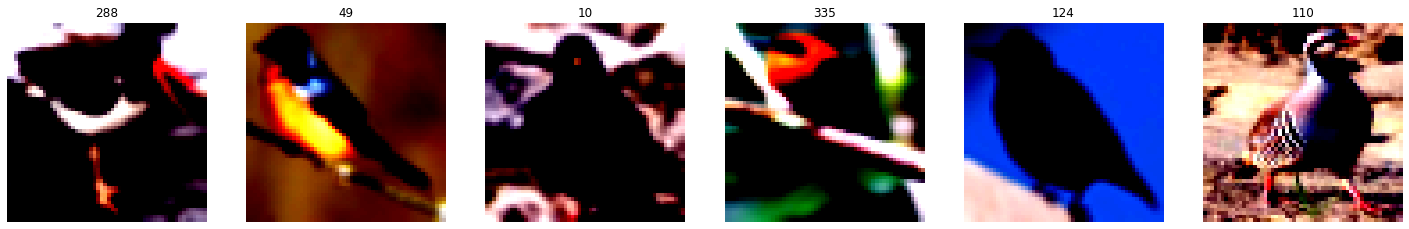

In [98]:
random.seed(42)
IMG_NUM = 6
indices = random.sample(list(range(len(birds_df))), IMG_NUM)
fig, axs = plt.subplots(1, IMG_NUM, figsize=(25, 25))
for index, ax in zip(indices, axs):
    image, label = datasets['transform_train'][index]
    ax.axis(False)
    ax.set(title=label)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(np.transpose(image.numpy(), [1, 2, 0]))
plt.show()

In [131]:
efficient_net_b0 = torchvision.models.efficientnet_b0(pretrained=False)
resnet18 = torchvision.models.resnet18(pretrained=False)
efficient_net_b0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=CLASSES_NUM, bias=True)
)

resnet18.fc = nn.Linear(in_features=512, out_features=CLASSES_NUM, bias=True)


Lets try training from scratch again:

In [132]:
criterion = nn.CrossEntropyLoss()

train_history_transform = []

for model in [efficient_net_b0, resnet18]:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_history_transform.append(
        train(model, criterion, optimizer, 
              train_dataloader=dataloaders['transform_train'],
              val_dataloader=dataloaders['transform_valid'])
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:50<00:00,  1.04it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 5.6307443701702615
Train accuracy = 0.012313179347826086
Val loss = 4.97038397192955
Val accuracy = 0.031835937523283064


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:49<00:00,  1.05it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 4.556711984717327
Train accuracy = 0.07211277173913043
Val loss = 4.151040226221085
Val accuracy = 0.11806640634313226


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:49<00:00,  1.05it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 3.7896809080372686
Train accuracy = 0.17089673915634984
Val loss = 3.2510600090026855
Val accuracy = 0.24980468768626451


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:49<00:00,  1.05it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 3.1619982055995774
Train accuracy = 0.2800101902173913
Val loss = 2.7158075124025345
Val accuracy = 0.34492187574505806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:49<00:00,  1.05it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 2.706900059658548
Train accuracy = 0.3684748641822649
Val loss = 2.5944929867982864
Val accuracy = 0.41289062425494194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:49<00:00,  1.05it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 2.517403797481371
Train accuracy = 0.4060631793478261
Val loss = 2.173935152590275
Val accuracy = 0.45371093787252903


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:50<00:00,  1.04it/s]


----------------------------------------------------------------------------------------------------
Epoch 7 ends
Train loss = 2.25779389505801
Train accuracy = 0.4599014945652174
Val loss = 1.7998464703559875
Val accuracy = 0.5349609367549419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:50<00:00,  1.04it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 1.9515690938286159
Train accuracy = 0.5222010871638423
Val loss = 1.624956950545311
Val accuracy = 0.5803710930049419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:49<00:00,  1.05it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 1.7384672071622767
Train accuracy = 0.5657167118528615
Val loss = 1.6127805709838867
Val accuracy = 0.5877929702401161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:50<00:00,  1.05it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 1.6172347130982772
Train accuracy = 0.5949456520702527
Val loss = 1.4415496066212654
Val accuracy = 0.6285156235098839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:40<00:00,  1.15it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 4.545948517840841
Train accuracy = 0.11243546190469161
Val loss = 3.770035684108734
Val accuracy = 0.18496093712747097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:40<00:00,  1.15it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 2.8910249564958654
Train accuracy = 0.3459578804347826
Val loss = 2.427921935915947
Val accuracy = 0.40712890587747097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:40<00:00,  1.15it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 2.1992577397305033
Train accuracy = 0.48194633152173916
Val loss = 2.0402484983205795
Val accuracy = 0.4989257827401161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:40<00:00,  1.15it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 1.7789736716643623
Train accuracy = 0.566120924120364
Val loss = 1.75696911662817
Val accuracy = 0.5578125007450581


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:41<00:00,  1.14it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 1.452270479824232
Train accuracy = 0.6378057065217392
Val loss = 1.3934810161590576
Val accuracy = 0.6510742194950581


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:40<00:00,  1.14it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 1.2160364886988764
Train accuracy = 0.6908933421839838
Val loss = 1.4293972849845886
Val accuracy = 0.6413085944950581


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:40<00:00,  1.14it/s]


----------------------------------------------------------------------------------------------------
Epoch 7 ends
Train loss = 1.0129846852758657
Train accuracy = 0.7360461955485137
Val loss = 1.1792453080415726
Val accuracy = 0.6970703117549419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:40<00:00,  1.14it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 0.8399245785630267
Train accuracy = 0.7775339675986248
Val loss = 1.118200670927763
Val accuracy = 0.7097656242549419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:40<00:00,  1.14it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 0.6613207218439683
Train accuracy = 0.8231182067290597
Val loss = 1.0413703545928001
Val accuracy = 0.7295898422598839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:40<00:00,  1.14it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 0.5363989055156708
Train accuracy = 0.8534103258796361
Val loss = 1.0677582062780857
Val accuracy = 0.7372070327401161


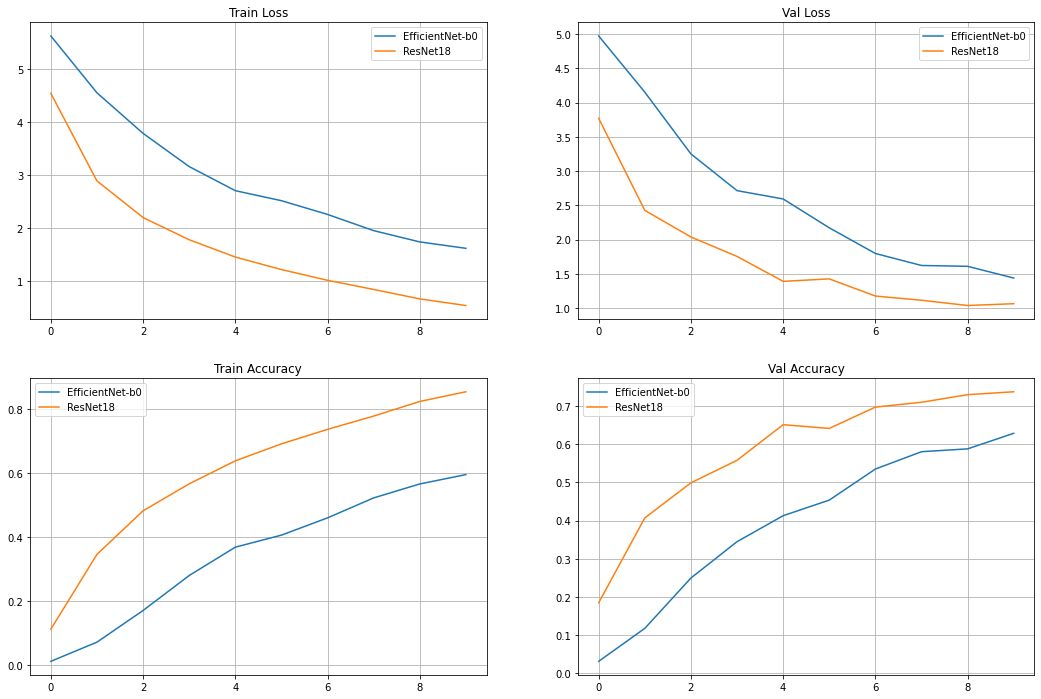

In [133]:
plot_train_histories(train_history_transform)

In this case, the arguments helped to reduce the ResNet overfitting.

As a final experiment, let's take the ResNet model, add arguments, increase the size of the image at the input by 2 times and use SpinalNet(https://arxiv.org/pdf/2007.03347v2.pdf) instead of FC layer.

I will not use lr_scheduler because I have too few training epochs.

In [205]:
resnet18 = torchvision.models.resnet18(pretrained=False)


In [159]:
layer_width = 256
in_features = resnet18.fc.in_features

half_in_size = in_features // 2

class SpinalNet(nn.Module):
    def __init__(self):
        super(SpinalNet, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(layer_width*4, CLASSES_NUM),)
        
        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x

In [200]:
resnet18.fc = SpinalNet()

train_transforms_2 = transforms.Compose([
    transforms.Resize(112),
    transforms.GaussianBlur([3, 3]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
]
)

val_transforms_2 = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

test_transforms_2 = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

datasets['transform_train_2'] = ImageFolder(
    os.path.join(DATA_PATH, 'train'),
    transform=train_transforms_2
)
dataloaders['transform_train_2'] = DataLoader(datasets['transform_train_2'], TRAIN_BATCH_SIZE // 2, NUM_WORKERS)

datasets['transform_valid_2'] = ImageFolder(
    os.path.join(DATA_PATH, 'valid'),
    transform=train_transforms_2
)
dataloaders['transform_valid_2'] = DataLoader(datasets['transform_valid_2'], VAL_BATCH_SIZE // 2, NUM_WORKERS)

datasets['transform_test_2'] = ImageFolder(
    os.path.join(DATA_PATH, 'test'),
    transform=train_transforms_2
)
dataloaders['transform_test_2'] = DataLoader(datasets['transform_test_2'], VAL_BATCH_SIZE // 2, NUM_WORKERS)

In [206]:
criterion = nn.CrossEntropyLoss()

train_history_transform_last = []

model = resnet18
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_history_transform_last.append(
    train(model, criterion, optimizer, 
          train_dataloader=dataloaders['transform_train_2'],
          val_dataloader=dataloaders['transform_valid_2'])
)

100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:22<00:00,  1.61it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 4.275383009140148
Train accuracy = 0.1380492631004367
Val loss = 3.327272467315197
Val accuracy = 0.2373046875


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:28<00:00,  1.54it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 2.4318031233991597
Train accuracy = 0.43017194312732815
Val loss = 2.3026384375989437
Val accuracy = 0.43212890625


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:27<00:00,  1.55it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 1.6873135603150946
Train accuracy = 0.58589997275948
Val loss = 1.3697692919522524
Val accuracy = 0.626953125


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:26<00:00,  1.56it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 1.28756106264206
Train accuracy = 0.6739901746724891
Val loss = 1.125778065994382
Val accuracy = 0.70458984375


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:27<00:00,  1.55it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 1.016125313840058
Train accuracy = 0.7371076691619174
Val loss = 0.9663422331213951
Val accuracy = 0.73974609375


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:23<00:00,  1.60it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 0.834778991588859
Train accuracy = 0.7790734169264548
Val loss = 0.8969434592872858
Val accuracy = 0.76318359375


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:26<00:00,  1.56it/s]


----------------------------------------------------------------------------------------------------
Epoch 7 ends
Train loss = 0.6871498648776758
Train accuracy = 0.8144241266896111
Val loss = 0.9214198235422373
Val accuracy = 0.759765625


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:24<00:00,  1.58it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 0.5526970359435769
Train accuracy = 0.8465474890829694
Val loss = 0.6570068979635835
Val accuracy = 0.82421875


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:28<00:00,  1.54it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 0.4579310630606772
Train accuracy = 0.872830240226729
Val loss = 0.7830380303785205
Val accuracy = 0.79541015625


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:28<00:00,  1.55it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 0.3653214474952898
Train accuracy = 0.8964792575898649
Val loss = 0.8110283939167857
Val accuracy = 0.78564453125


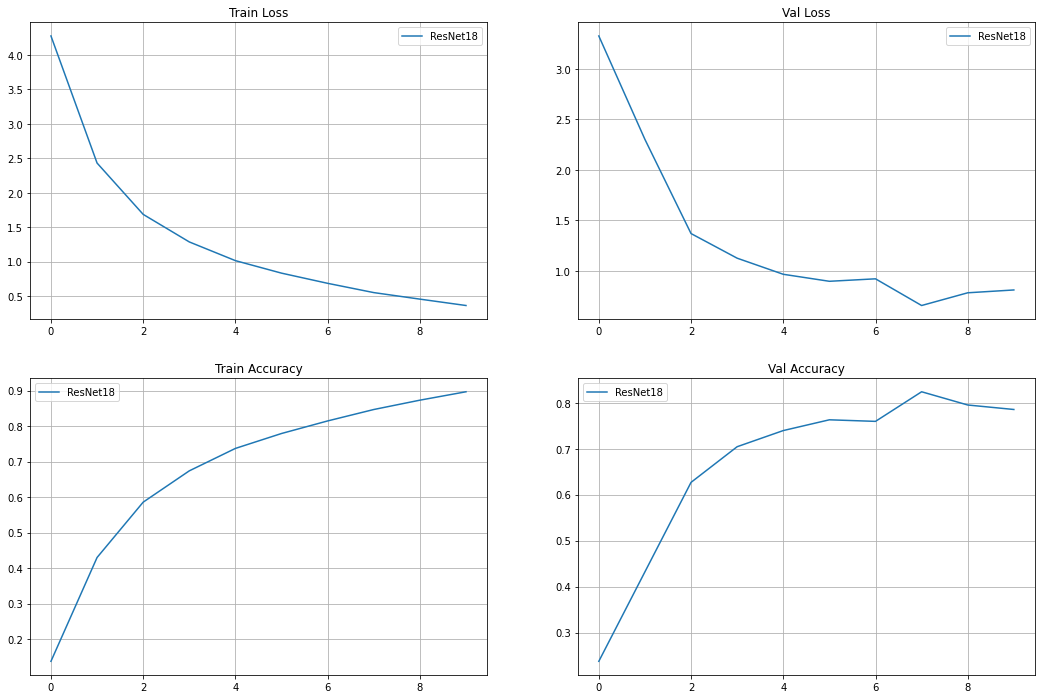

In [207]:
plot_train_histories(train_history_transform_last, model_names=['ResNet18'])

Currently best result without using pretraining model.

And lets do the same for pretrained ResNet model.

In [165]:
resnet18_pretrained = torchvision.models.resnet18(pretrained=True)
resnet18_pretrained.fc = SpinalNet()

criterion = nn.CrossEntropyLoss()

train_history_final_pretrained = []

model = resnet18_pretrained
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_history_final_pretrained.append(
    train(model, criterion, optimizer, 
          train_dataloader=dataloaders['transform_train_2'],
          val_dataloader=dataloaders['transform_valid_2'])
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:27<00:00,  1.55it/s]


----------------------------------------------------------------------------------------------------
Epoch 1 ends
Train loss = 3.475330451690474
Train accuracy = 0.2709061135110897
Val loss = 1.8323045447468758
Val accuracy = 0.533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:26<00:00,  1.56it/s]


----------------------------------------------------------------------------------------------------
Epoch 2 ends
Train loss = 1.4778358764523503
Train accuracy = 0.6208276472757998
Val loss = 0.8510558512061834
Val accuracy = 0.7666015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:26<00:00,  1.56it/s]


----------------------------------------------------------------------------------------------------
Epoch 3 ends
Train loss = 0.9781377739781375
Train accuracy = 0.7373567140258556
Val loss = 0.5605753818526864
Val accuracy = 0.83984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:27<00:00,  1.55it/s]


----------------------------------------------------------------------------------------------------
Epoch 4 ends
Train loss = 0.7251165553471928
Train accuracy = 0.8015659115720524
Val loss = 0.5860108537599444
Val accuracy = 0.830078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:23<00:00,  1.59it/s]


----------------------------------------------------------------------------------------------------
Epoch 5 ends
Train loss = 0.5936152493849592
Train accuracy = 0.8335732804635727
Val loss = 0.456641583237797
Val accuracy = 0.87255859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:26<00:00,  1.56it/s]


----------------------------------------------------------------------------------------------------
Epoch 6 ends
Train loss = 0.4895859800571958
Train accuracy = 0.8618961517987813
Val loss = 0.539167907088995
Val accuracy = 0.8515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:27<00:00,  1.56it/s]


----------------------------------------------------------------------------------------------------
Epoch 8 ends
Train loss = 0.3526529555237449
Train accuracy = 0.8978131822102976
Val loss = 0.35618091095238924
Val accuracy = 0.89892578125


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:27<00:00,  1.55it/s]


----------------------------------------------------------------------------------------------------
Epoch 9 ends
Train loss = 0.29573335195993233
Train accuracy = 0.9141307314410481
Val loss = 0.4741113814525306
Val accuracy = 0.87646484375


100%|██████████████████████████████████████████████████████████████████████████████████████| 229/229 [02:27<00:00,  1.55it/s]


----------------------------------------------------------------------------------------------------
Epoch 10 ends
Train loss = 0.29231178200921637
Train accuracy = 0.9150075053544023
Val loss = 0.3033443393651396
Val accuracy = 0.91455078125


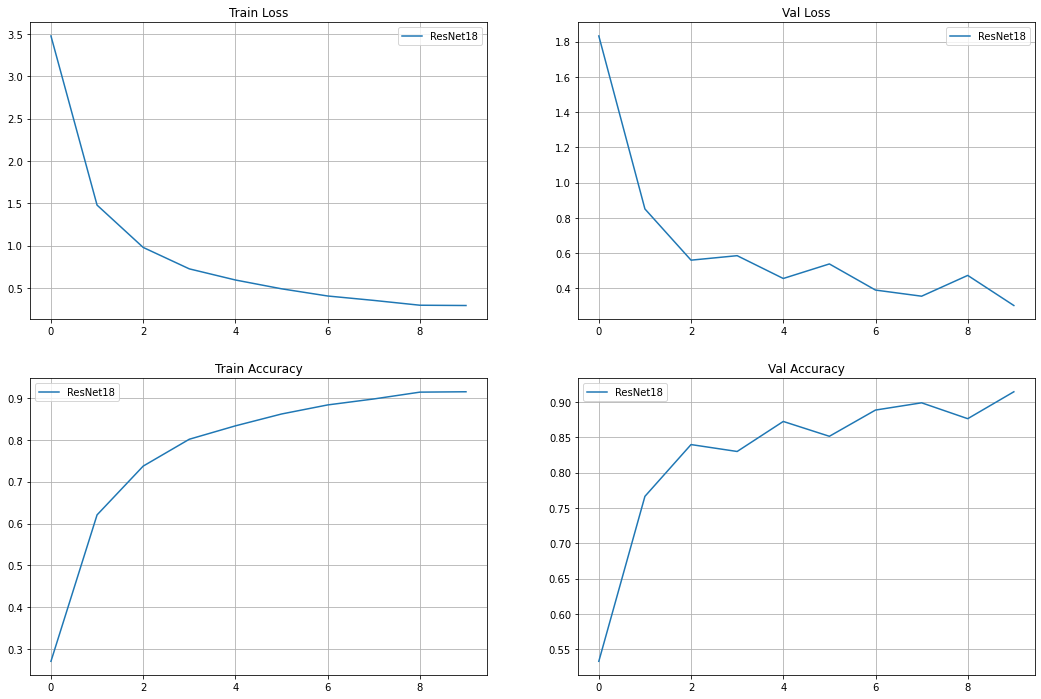

In [166]:
plot_train_histories(train_history_final_pretrained, model_names=['ResNet18'])

And this is the best result with pretraining models

Lets test two last models on test set.

In [202]:
def test_model(model, test_dataloader):
    model = model.to(device)
    correct_preds = 0
    model.eval()
    model.to(device)
    for images, targets in tqdm(test_dataloader):
        images = images.to(device)
        targets = targets.to(device)
        preds = model(images)
        correct_preds += torch.sum(torch.argmax(preds, dim=1) == targets).detach().cpu()
    return correct_preds / 2000

In [208]:
print('Pretrained model accuracy: ', test_model(resnet18_pretrained, dataloaders['transform_test_2']).item())
print('From scratch model accuracy: ', test_model(resnet18, dataloaders['transform_test_2']).item())

100%|████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Pretrained model accuracy:  0.9394999742507935


100%|████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.24it/s]

From scratch model accuracy:  0.8165000081062317
